# 決定木学習

決定木分類器は、意味解釈可能性（得られた結果の意味を解釈しやすいかどうか）に配慮する場合に魅力てきなモデルである。

「決定木」という名前が示唆するように、このモデルについては、一連の質問に基づいて決断を下すという方法により、データを分類するモデルである。

決定木アルゴリズムを使用して、決定木の根（ルート）から始めて、`情報利得`（分割された集合の要素についてのばらつきの減少）が最大となる特徴量でデータを分割する。

最も情報利得の高い特徴量でノードを分割するには、決定木学習アルゴリズムを使った最適化の対象となる目的関数を定義する必要がある。
またその目的関数で主に行なっていることからわかることとして、情報利得は`親ノードの不純度`と`子ノードの不純度`との差にすぎないことがわかる。

ほとんどのライブラリでは、二分決定木を実装しており、親ノードはそれぞれ2つの子ノードDleftとDrightに分かれる。

二分決定木でよく使用される不純度の指標または分割条件は、`ジニ不純度（Gini impurity）`、`エントロピー（entropy）`、`分類誤差（classification error）`の3つである。


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# ジュピターノートブック上でグラフを表示させるための処理
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Irisデータセットの取得と整形

In [4]:
# Irisデータセットをロード
iris = datasets.load_iris()

# 3, 4列目の特徴量を抽出
X = iris.data[:, [2, 3]]

# クラスラベルを取得
y = iris.target

# トレーニングデータとテストデータに分割
## 全体の30%をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Irisデータセットを標準化
sc = StandardScaler()

# トレーニングデータの平均と標準偏差を計算
sc.fit(X_train)

# 平均と標準偏差を用いて標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## 2次元のデータセットの決定境界の可視化

In [15]:
# 色のリストからカラーマップを作成するためにListedColormapをインポート
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの生成
    ## meshgrid関数を使用し、Irisデータセットと同じ個数の列を持つ行列を作成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                                              np.arange(x2_min, x2_max, resolution))
    
   # 各特徴量を1次元配列に変換して予測を実行 
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    
    # グリッドポイントの等高線のプロット
    ## グリッド配列内の予測されたクラスごとに、決定領域をそれぞれ異なる色にマッピングする。
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
    
    # テストサンプルを目立たせる（点をoで表示）
    if test_idx:
        X_test, y_test, = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', alpha=1.0, linewidths=1, marker='o', s=55, label='test set')

## 3種類の不純度条件を視覚的に比較する

ジニ不純度がエントロピーと分類誤差の中間に位置付けられることを確認するために、エントロピーを2で割ったスケーリングバージョンも追加する。

In [2]:
# ジニ不純度の関数の定義
def gini(p):
    return (p * (1 - p)) + ((1 - p) * (1 - (1 - p)))

# エントロピーの関数を定義
def entropy(p):
    return - (p * np.log2(p)) - ((1 - p) * np.log2(1 - p))

# 分類誤差の関数を定義
def error(p):
    return 1 - np.max([p, (1 - p)])

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


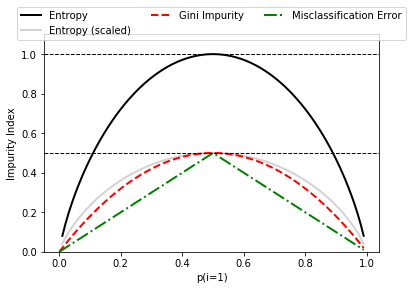

In [3]:
# 確率を表す配列を生成（0から0.99まで0.01刻み）
x = np.arange(0.0, 1.0, 0.01)

# 配列の値をもとにエントロピー、分類誤差を計算
## エントロピーを2で割ったスケーリングバージョンも追加
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

# 図の作成を開始
fig = plt.figure()
ax = plt.subplot(111)

# エントロピー（2種）、ジニ不純度、分類誤差のそれぞれをループ処理
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                                    ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
                                    ['-', '-', '--', '-.'],
                                    ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

# 凡例の設定（中央の上に配置）
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=False)

# 2本の水平の破線を引く
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

# 横軸の上限と下限を設定
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

## 決定木の構築

決定木学習では、特徴空間を短形に分割することで複雑な決定境界を構築できる。ただし、決定木が深くなればなるほど決定境界は複雑になり、過学習に陥りやすくなるため、注意が必要である。

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


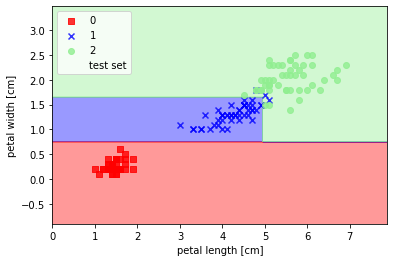

In [16]:
from sklearn.tree import DecisionTreeClassifier

# エントロピーを指標とする決定木のインスタンスを生成
## criterion(基準)で不純度条件を指定する。
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

# 決定木のモデルにトレーニングデータを適合させる
tree.fit(X_train, y_train)
# トレーニングデータとテストデータの特徴量の行方向に結合
X_combined = np.vstack((X_train, X_test))
# トレーニングデータとテストデータのクラスラベルを結合
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, y_combined, classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

## 決定木グラフの可視化

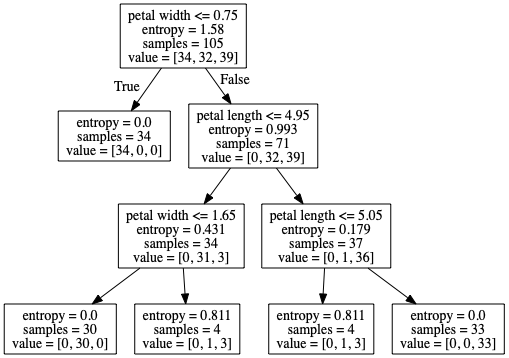

In [17]:
# 決定木の可視化をするために必要
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

export_graphviz(tree, out_file="tree.dot", feature_names=['petal length', 'petal width'])
# 決定木を表示
g = pydotplus.graph_from_dot_file(path="tree.dot")
Image(g.create_png())

⬆︎

GraphVizで作成した決定木の図を見ると、決定木がトレーニングデータセットから判定した分割を正確にたどることができる。根の105個のサンプルを出発点として、花びらの長さがしきい値0.75cm以下であることに基づき、34個と71個のサンプルを持つ2つの子ノードに分割する。

最初の分割の後、左の子ノードがすでに純粋であり、Iris-Setosaクラスのサンプルだけを含んでいることがわかる（`エントロピーが0になっているため`）。そこで、右の子ノードでさらに分割を行い、サンプルをIris-VersicolorクラスとIris-Virginicaクラスに分割している。